In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from gensim.utils import dict_from_corpus
import gensim
from gensim.corpora import Dictionary
from collections import Counter
from gensim.models import tfidfmodel
import scipy
import h5py

### Open file

In [2]:
path = os.getcwd()
filename = '/data/table.csv'
df = pd.read_csv(path + filename, index_col=0)

Since the words in sentences are meaningless I don't use any words embeddings (like word2vec or Fasttext) and use only sentence embeddings

### Make a global dictionary

In [3]:
# tokenize the sentences
def tokenize(sentence):
    return sentence.split(' ')

df['tokenized'] = df.bow_enc.apply(lambda sentence: tokenize(sentence))

In [4]:
df.head()

,status,bow_enc,tokenized
0,fraud,ОТДЕЛИЛ ТИБЕРИЙ МУК ПОДЛОСТЯХ МАЯЧИЛА СУЕВЕРНЫ...,"[ОТДЕЛИЛ, ТИБЕРИЙ, МУК, ПОДЛОСТЯХ, МАЯЧИЛА, СУ..."
1,good,СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ ВРАЩАЮЩИЕСЯ ПОЛО...,"[СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ВРАЩАЮЩИЕСЯ,..."
2,fraud,РАССЧИТАНО СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ УПОМЯ...,"[РАССЧИТАНО, СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ..."
3,good,ОТДЕЛИЛ МУК НЕГОДНЫМИ ОСКОРБЛЕНИЯМ РЕДКОСТЬ ПЕ...,"[ОТДЕЛИЛ, МУК, НЕГОДНЫМИ, ОСКОРБЛЕНИЯМ, РЕДКОС..."
4,fraud,МУК ПОДЛОСТЯХ РЯСКОЙ НАДЕЛИЛИ ПАЦАНОМ УСТАНАВЛ...,"[МУК, ПОДЛОСТЯХ, РЯСКОЙ, НАДЕЛИЛИ, ПАЦАНОМ, УС..."


In [5]:
dictionary = Dictionary(df.tokenized)
print(len(dictionary))

# filter the dictionary
dictionary.filter_extremes(no_below=5, no_above=0.8)
print(len(dictionary))

35970
10861


There are extremely many words that appear less than in 5 documents (sentences) at least 

### BOW representation (indices)

In [6]:
def sent_to_bow(tok_sent):
    res = [i for i in dictionary.doc2idx(tok_sent)]
    return list(filter(lambda a: a >= 0, res))  # remove non-dict words

def lstm_embed(tok_sent):
    # 0 will be used to pad the sequence
    res = [i + 1 for i in dictionary.doc2idx(tok_sent)]
    return list(filter(lambda a: a > 0, res))

df['bow_index'] = df.tokenized.apply(lambda tok_sent: sent_to_bow(tok_sent))
df['lstm_embed'] = df.tokenized.apply(lambda tok_sent: lstm_embed(tok_sent))

In [7]:
df.head()

,status,bow_enc,tokenized,bow_index,lstm_embed
0,fraud,ОТДЕЛИЛ ТИБЕРИЙ МУК ПОДЛОСТЯХ МАЯЧИЛА СУЕВЕРНЫ...,"[ОТДЕЛИЛ, ТИБЕРИЙ, МУК, ПОДЛОСТЯХ, МАЯЧИЛА, СУ...","[28, 10, 17, 8, 26, 27, 30, 1, 21, 7, 19, 2, 6...","[29, 11, 18, 9, 27, 28, 31, 2, 22, 8, 20, 3, 7..."
1,good,СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ ВРАЩАЮЩИЕСЯ ПОЛО...,"[СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ВРАЩАЮЩИЕСЯ,...","[114, 17, 124, 93, 102, 26, 27, 121, 87, 117, ...","[115, 18, 125, 94, 103, 27, 28, 122, 88, 118, ..."
2,fraud,РАССЧИТАНО СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ УПОМЯ...,"[РАССЧИТАНО, СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ...","[200, 114, 17, 124, 220, 167, 26, 27, 121, 213...","[201, 115, 18, 125, 221, 168, 27, 28, 122, 214..."
3,good,ОТДЕЛИЛ МУК НЕГОДНЫМИ ОСКОРБЛЕНИЯМ РЕДКОСТЬ ПЕ...,"[ОТДЕЛИЛ, МУК, НЕГОДНЫМИ, ОСКОРБЛЕНИЯМ, РЕДКОС...","[10, 168, 237, 109, 238, 93, 233, 230, 156, 22...","[11, 169, 238, 110, 239, 94, 234, 231, 157, 22..."
4,fraud,МУК ПОДЛОСТЯХ РЯСКОЙ НАДЕЛИЛИ ПАЦАНОМ УСТАНАВЛ...,"[МУК, ПОДЛОСТЯХ, РЯСКОЙ, НАДЕЛИЛИ, ПАЦАНОМ, УС...","[10, 17, 203, 244, 175, 121, 247, 135, 21, 170...","[11, 18, 204, 245, 176, 122, 248, 136, 22, 171..."


### Visual comparison

in order to find a feature that can easily separate two classes between each other. In particular, if some word is only used in one class sentences

In [8]:
good = df[df.status == 'good']
fraud = df[df.status == 'fraud']

In [9]:
# count repetitions of words for each class separately
g = Counter()
f = Counter()
def count_words(counter, arr):
    counter.update(arr)
    pass

tmp = good.bow_index.apply(lambda arr_of_idx: count_words(g, arr_of_idx))
tmp = fraud.bow_index.apply(lambda arr_of_idx: count_words(f, arr_of_idx))

In [10]:
# data for plot
x_good = sorted(g.keys())
y_good = [g[idx] for idx in x_good]
x_fraud = sorted(f.keys())
y_fraud = [f[idx] for idx in x_fraud]

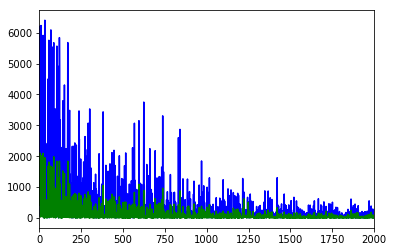

In [11]:
plt.plot(x_good, y_good, color='blue')
plt.xlim((0, 2000))
plt.plot(x_fraud, y_fraud, color='green')

In [12]:
# normalize the data to plot graphs with one scale
y_good_norm = y_good - np.mean(y_good)
y_good_norm /= np.std(y_good)

y_fraud_norm = y_fraud - np.mean(y_fraud)
y_fraud_norm /= np.std(y_fraud)

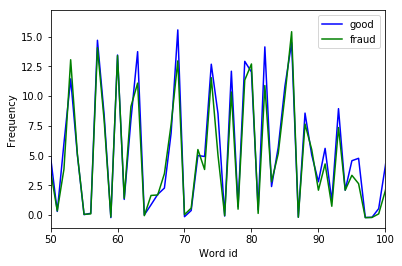

In [13]:
plt.plot(x_good, y_good_norm, color='blue', label='good')
plt.xlim((50, 100))
plt.plot(x_fraud, y_fraud_norm, color='green', label='fraud')
plt.xlabel("Word id")
plt.ylabel("Frequency")
plt.legend()

### Make a fixed-length vector representation for a sentence

Use TF for each sentence

In [14]:
# first is to make BOW representation
df['bow'] = df.tokenized.apply(dictionary.doc2bow)

In [15]:
tfidf = tfidfmodel.TfidfModel(dictionary=dictionary)

In [16]:
def to_tfidf(sequence):
    return tfidf[sequence]

df['tfidf'] = df.bow.apply(lambda seq: to_tfidf(seq))

In [17]:
vec_len = len(dictionary)  # length of the fixed-length vector for each sentence

def to_tf(sequence):
    vec = np.zeros(vec_len)
    for idx in sequence:
        vec[idx] += 1
    return vec

df['tf'] = df.bow_index.apply(lambda seq: to_tf(seq))

In [18]:
df.head()

,status,bow_enc,tokenized,bow_index,lstm_embed,bow,tfidf,tf
0,fraud,ОТДЕЛИЛ ТИБЕРИЙ МУК ПОДЛОСТЯХ МАЯЧИЛА СУЕВЕРНЫ...,"[ОТДЕЛИЛ, ТИБЕРИЙ, МУК, ПОДЛОСТЯХ, МАЯЧИЛА, СУ...","[28, 10, 17, 8, 26, 27, 30, 1, 21, 7, 19, 2, 6...","[29, 11, 18, 9, 27, 28, 31, 2, 22, 8, 20, 3, 7...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.07896328187459432), (1, 0.0263124762577...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,good,СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ ВРАЩАЮЩИЕСЯ ПОЛО...,"[СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ВРАЩАЮЩИЕСЯ,...","[114, 17, 124, 93, 102, 26, 27, 121, 87, 117, ...","[115, 18, 125, 94, 103, 27, 28, 122, 88, 118, ...","[(1, 1), (2, 1), (3, 1), (4, 1), (9, 1), (10, ...","[(1, 0.012902884061771744), (2, 0.020152021935...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,fraud,РАССЧИТАНО СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ УПОМЯ...,"[РАССЧИТАНО, СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ...","[200, 114, 17, 124, 220, 167, 26, 27, 121, 213...","[201, 115, 18, 125, 221, 168, 27, 28, 122, 214...","[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (9, 1...","[(0, 0.03242952472186803), (1, 0.0108063023602...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,good,ОТДЕЛИЛ МУК НЕГОДНЫМИ ОСКОРБЛЕНИЯМ РЕДКОСТЬ ПЕ...,"[ОТДЕЛИЛ, МУК, НЕГОДНЫМИ, ОСКОРБЛЕНИЯМ, РЕДКОС...","[10, 168, 237, 109, 238, 93, 233, 230, 156, 22...","[11, 169, 238, 110, 239, 94, 234, 231, 157, 22...","[(0, 1), (1, 1), (3, 1), (5, 1), (6, 1), (10, ...","[(0, 0.06892141990707379), (1, 0.0229662848593...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
4,fraud,МУК ПОДЛОСТЯХ РЯСКОЙ НАДЕЛИЛИ ПАЦАНОМ УСТАНАВЛ...,"[МУК, ПОДЛОСТЯХ, РЯСКОЙ, НАДЕЛИЛИ, ПАЦАНОМ, УС...","[10, 17, 203, 244, 175, 121, 247, 135, 21, 170...","[11, 18, 204, 245, 176, 122, 248, 136, 22, 171...","[(9, 1), (10, 1), (12, 1), (13, 1), (17, 1), (...","[(9, 0.058340591357490444), (10, 0.02035068493...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### tfidf to vector representation

In [19]:
def tfidf_to_vector(seq_of_tuples):
    vec = np.zeros(vec_len)

    for idx, val in seq_of_tuples:
        vec[idx] = val
        
    return vec

df['tfidf_vec'] = df.tfidf.apply(lambda seq: tfidf_to_vector(seq))

In [20]:
df.head()

,status,bow_enc,tokenized,bow_index,lstm_embed,bow,tfidf,tf,tfidf_vec
0,fraud,ОТДЕЛИЛ ТИБЕРИЙ МУК ПОДЛОСТЯХ МАЯЧИЛА СУЕВЕРНЫ...,"[ОТДЕЛИЛ, ТИБЕРИЙ, МУК, ПОДЛОСТЯХ, МАЯЧИЛА, СУ...","[28, 10, 17, 8, 26, 27, 30, 1, 21, 7, 19, 2, 6...","[29, 11, 18, 9, 27, 28, 31, 2, 22, 8, 20, 3, 7...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.07896328187459432), (1, 0.0263124762577...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.07896328187459432, 0.02631247625778799, 0.0..."
1,good,СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ ВРАЩАЮЩИЕСЯ ПОЛО...,"[СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ВРАЩАЮЩИЕСЯ,...","[114, 17, 124, 93, 102, 26, 27, 121, 87, 117, ...","[115, 18, 125, 94, 103, 27, 28, 122, 88, 118, ...","[(1, 1), (2, 1), (3, 1), (4, 1), (9, 1), (10, ...","[(1, 0.012902884061771744), (2, 0.020152021935...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.012902884061771744, 0.0201520219354481..."
2,fraud,РАССЧИТАНО СПОСОБНОСТЬЮ ПОДЛОСТЯХ ФИРМАМ УПОМЯ...,"[РАССЧИТАНО, СПОСОБНОСТЬЮ, ПОДЛОСТЯХ, ФИРМАМ, ...","[200, 114, 17, 124, 220, 167, 26, 27, 121, 213...","[201, 115, 18, 125, 221, 168, 27, 28, 122, 214...","[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (9, 1...","[(0, 0.03242952472186803), (1, 0.0108063023602...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.03242952472186803, 0.010806302360262494, 0...."
3,good,ОТДЕЛИЛ МУК НЕГОДНЫМИ ОСКОРБЛЕНИЯМ РЕДКОСТЬ ПЕ...,"[ОТДЕЛИЛ, МУК, НЕГОДНЫМИ, ОСКОРБЛЕНИЯМ, РЕДКОС...","[10, 168, 237, 109, 238, 93, 233, 230, 156, 22...","[11, 169, 238, 110, 239, 94, 234, 231, 157, 22...","[(0, 1), (1, 1), (3, 1), (5, 1), (6, 1), (10, ...","[(0, 0.06892141990707379), (1, 0.0229662848593...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.06892141990707379, 0.0229662848593099, 0.0,..."
4,fraud,МУК ПОДЛОСТЯХ РЯСКОЙ НАДЕЛИЛИ ПАЦАНОМ УСТАНАВЛ...,"[МУК, ПОДЛОСТЯХ, РЯСКОЙ, НАДЕЛИЛИ, ПАЦАНОМ, УС...","[10, 17, 203, 244, 175, 121, 247, 135, 21, 170...","[11, 18, 204, 245, 176, 122, 248, 136, 22, 171...","[(9, 1), (10, 1), (12, 1), (13, 1), (17, 1), (...","[(9, 0.058340591357490444), (10, 0.02035068493...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Save embedding and target

In [21]:
def transform_status(status):
    if status == 'good':
        return 0
    return 1


def save_data(X, Y, filename):
    
    print(X.shape, Y.shape)
    
    with h5py.File(filename, 'w') as h5file:
        h5file.create_dataset('train', data=X)
        h5file.create_dataset('target', data=Y)
        h5file.close()
    
    print(filename, 'is saved')


In [22]:
Y_train = df.status.apply(lambda status: transform_status(status))

# save BOW encoding
X_train = np.stack(df.tf.values)
save_data(X_train, Y_train, 'data/embedded_bow.h5')

# save TFIDF encoding
X_train = np.stack(df.tfidf_vec.values)
save_data(X_train, Y_train, 'data/embedded_tfidf.h5')

(10868, 10861) (10868,)
data/embedded_bow.h5 is saved
(10868, 10861) (10868,)
data/embedded_tfidf.h5 is saved


### Save LSTM embedding

In [23]:
df[['status', 'lstm_embed']].to_json('data/embedding_LSTM.json')